[DNN 기반 이진분류 모델 구현]
- 데이터셋: iris.csv
- feature: 4개 (Sepal_Length, Sepal_Width, Petal_Length, Petal_Width)
- target: 1개 (Setosa or other)
- 학습: 지도 학습 중 분류
- 학습 알고리즘: 인공신경망(ANN) 중 심층신경망(DNN)  <- 은닉층이 많은 구성
- 프레임워크: Pytorch
- - -
- 모니터링
    - 기준 설정: 검증 데이터셋의 loss와 score
    - 평가: 학습 데이터셋의 loss 또는 score와 비교 -> 학습 중단 여부 결정
    - 선택: 현재까지 진행된 모델의 파라미터(가중치, 절편) 저장 여부 또는 모델 전체 저장
- - - 
- 진행 파라미터 저장

[1] 모듈 로딩 및 데이터 준비

In [105]:
#모듈 로딩
# Model 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score,BinaryF1Score,BinaryAccuracy
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary

# Data 및 시각화 관련
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split

In [106]:
#활용 패키지 버전 체크
print(f'torch  v.{torch.__version__}')
print(f'pandas v.{pd.__version__}')

torch  v.2.4.1
pandas v.2.0.3


In [107]:
torch.manual_seed(2)

In [108]:
#데이터 로딩
data_file='../data/iris.csv'

#csv -> DataFrame
iris_df=pd.read_csv(data_file)
iris_df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [109]:
#타겟 변경: 정수화, 클래스 2개로 바꾸는 작업 필요

#3개의 클래스를 2개로 바꾸기기
iris_df['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [110]:
iris_df['variety']=(iris_df['variety']=='Setosa')

In [111]:
iris_df

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,True
1,4.9,3.0,1.4,0.2,True
2,4.7,3.2,1.3,0.2,True
3,4.6,3.1,1.5,0.2,True
4,5.0,3.6,1.4,0.2,True
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,False
146,6.3,2.5,5.0,1.9,False
147,6.5,3.0,5.2,2.0,False
148,6.2,3.4,5.4,2.3,False


In [112]:
iris_df['variety']=iris_df['variety'].astype('int')

In [113]:
iris_df['variety'].unique()

array([1, 0])

In [114]:
# labels=dict(zip(iris_df['variety'].unique().tolist(),range(3)))
# iris_df['variety']=iris_df['variety'].replace(labels)

iris_df['variety'].value_counts()

variety
0    100
1     50
Name: count, dtype: int64

- - - 
[2] 모델 클래스 설계 및 정의
- 클래스 목적: iris 데이터 학습 및 추론
- 클래스 이름: iris_bcf_model
- 부모 클래스: nn.Module
- 매개변수: 각 층별 입출력 개수 고정 => 필요 X
- 클래스 속성: feature_df, target_df, n_rows, n_features
- 클래스 기능: _ _ init _ _( ) <- 모델 구조 설정, forward() <- 순방향 학습(오버라이딩(상속 관계에서만 가능) 필요)
- 클래스 구조
    - 입력층:  4개 입력 (feature 개수) 10개 출력 (=퍼셉트론 10개) 
    - 은닉층: 10개 입력                 5개 출력 (=퍼셉트론 30개)
    - 출력층:  5개 입력                 1개 출력 (이진분류의 결과)

- 활성화함수
    - 클래스 형태 (대문자로 시작)
        - nn.MSELoss, nn.ReLU 등
        - _ _init_ _() 메서드에서 사용됨
        - 하나의 층처럼 사용 가능
    - 함수 형태 (소문자로 시작)
        - torch.nn.functional.relu 등
        - forward 메서드에 사용됨

In [115]:
class iris_bcf_model(nn.Module):

    #모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()

        self.in_layer=nn.Linear(4,10)
        self.hidden_layer=nn.Linear(10,5)
        self.out_layer=nn.Linear(5,1)

    #순방향 학습 진행 메서드
    def forward(self,input_data):

        #입력층
        y=self.in_layer(input_data)     
        y=F.relu(y)                     # y 값: 0 이상

        #은닉층
        y=self.hidden_layer(y)
        y=F.relu(y)

        #출력층
        return F.sigmoid(self.out_layer(y))

In [116]:
#모델 인스턴스 생성_확인용
model=iris_bcf_model()

print(model)

iris_bcf_model(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [117]:
summary(model,input_size=(17,4))

Layer (type:depth-idx)                   Output Shape              Param #
iris_bcf_model                           [17, 1]                   --
├─Linear: 1-1                            [17, 10]                  50
├─Linear: 1-2                            [17, 5]                   55
├─Linear: 1-3                            [17, 1]                   6
Total params: 111
Trainable params: 111
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

- - -
[3] 데이터셋 클래스 설계 및 정의
- 데이터셋: iris.csv
- feature: 4개
- target: 1개
- 클래스 이름: iris_ds
- 부모 클래스: utils.data.Dataset
- 클래스 속성(필드): feature_df,target_df,n_rows,n_features
- 필수 메서드: 
    - _ _ init _ _ (self): 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    - _ _ len _ _ (self): 데이터 개수 반환
    - _ _ getItem _ _ (self): 특정 인덱스의 feature/target 반환

In [118]:
class iris_dataset(Dataset):
    def __init__(self,feature_df,target_df):
        self.feature_df=feature_df
        self.target_df=target_df

        self.n_rows=feature_df.shape[0]
        self.n_features=feature_df.shape[1]

    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):

        #tensor화
        feature_ts=torch.FloatTensor(self.feature_df.iloc[index].values)
        target_ts=torch.FloatTensor(self.target_df.iloc[index].values)

        #feature/target 반환
        return feature_ts,target_ts

In [119]:
#데이터셋 인스턴스 생성

feature_df=iris_df[iris_df.columns[:-1]]    #2D (150,3)
target_df=iris_df[iris_df.columns[-1:]]     #2D (150,1)

iris_ds=iris_dataset(feature_df,target_df)

iris_dl=DataLoader(iris_ds)
for feature,label in iris_dl:
    print(feature.shape,label.shape, feature,label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[1.]])


- - -
[4] 학습 준비
- 학습 횟수: EPOCH          #회독 횟수
- 배치 크기: BATCH_SIZE     #한번에 학습할 데이터 양
- 위치 지정: DEVICE         #텐서 저장 및 실행 위치 (GPU or CPU)
- 학습률(LR)
    - 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정
    - 0.001 ~ 0.1 사이 값 주로 사용

In [120]:
#학습 진행 관련 설정

EPOCH=1000         #처음에 1로 설정해서 잘 돌아가는지 확인하고 올리기
BATCH_SIZE=10
BATCH_CNT=iris_df.shape[0]//BATCH_SIZE
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
LR=0.001

print(f'BATCH_CNT: {BATCH_CNT}')

BATCH_CNT: 15


- 인스턴스: 모델, 데이터셋, 최적화, (손실함수, 성능지표)

In [121]:
#모델 인스턴스
model=iris_bcf_model().to(DEVICE)

#데이터셋 인스턴스
x_train,x_test,y_train,y_test=train_test_split(feature_df,target_df,random_state=1,stratify=target_df)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,random_state=1,stratify=y_train)

print(f'x_train: {x_train.shape}, x_test: {x_test.shape}, x_val: {x_val.shape}')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}, y_val: {y_val.shape}')
print(f'{y_train.value_counts()/y_train.shape[0]}, {y_test.value_counts()/y_train.shape[0]},{y_val.value_counts()/y_train.shape[0]}')
print(f'{type(x_train)}, {type(x_test)}, {type(x_val)}')

#iris_ds=iris_dataset(feature_df,target_df)

train_ds=iris_dataset(x_train,y_train)
val_ds=iris_dataset(x_val,y_val)
test_ds=iris_dataset(x_test,y_test)

#최적화 인스턴스
iris_dl=DataLoader(train_ds,batch_size=BATCH_SIZE)

x_train: (84, 4), x_test: (38, 4), x_val: (28, 4)
y_train: (84, 1), y_test: (38, 1), y_val: (28, 1)
variety
0          0.666667
1          0.333333
Name: count, dtype: float64, variety
0          0.297619
1          0.154762
Name: count, dtype: float64,variety
0          0.226190
1          0.107143
Name: count, dtype: float64
<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.frame.DataFrame'>


- 최적화, 손실함수 인스턴스 생성

In [122]:
#최적화 인스턴스: model.parameters() 전달
optimizer=optim.Adam(model.parameters(), lr=LR)

#손실함수 인스턴스: 이진분류 => BinaryCrossEntropyLoss(BCELoss) 사용
#                             예측값을 확률값으로 전달 => Sigmoid() AF 처리 후 전달
binary_loss=nn.BCELoss()

- - -
[5] 학습 진행

- 모델 저장

In [123]:
#경로 상 폴더 존재 여부 체크
if not os.path.exists(save_path):
    os.makedirs(save_path)  #하위 폴더까지 생성 가능

In [124]:
#models 폴더 아래 프로젝트 폴더 아래 모델 파일 저장
import os

save_path='../models/iris/BCF/'
save_File=save_path+'model.train_wbs.pth'
save_model=save_path+'model_all.pth'

- 학습 진행

In [127]:
#학습 확인 w. 손실값, 성능평가 지표

loss_history=[[],[]]
score_history=[[],[]]

CNT = len(iris_dl)
print(f'CNT : {CNT}')

#BATCH_CNT=iris_ds.n_rows/BATCH_SIZE

#학습 모니터링/스케줄링 설정: loss_history, score_history 활용
# - 임계 기준: 10번
break_count=0
limit=10

for epoch in range(EPOCH):

    #학습 모드로 모델 설정
    model.train()

    total_loss=0
    total_score=0

    for feature_ts,target_ts in iris_dl:

        #학습 진행
        pre_y=model(feature_ts)

        #손실 계산
        loss=binary_loss(pre_y,target_ts)
        total_loss+=loss.item()

        #성능 평가
        score=BinaryF1Score()(pre_y,target_ts)
        #score=F1Score(task='binary,zero_division=1.0)(pre_y,target_ts)
        total_score+=score.item()

        #최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #각 에포크 당 검증 수행: 모델을 검증 모드로 설정
    model.eval()

    with torch.no_grad():
        #검증 데이터셋
        val_feature_ts=torch.FloatTensor(val_ds.feature_df.values)
        val_target_ts=torch.FloatTensor(val_ds.target_df.values)
        
        #평가
        pre_val=model(val_feature_ts)

        #손실 계산
        val_loss=binary_loss(pre_val,val_target_ts)

        #성능 평가
        val_score=BinaryF1Score()(pre_val,val_target_ts)

    #손실값, 성능평가값 저장
    loss_history[0].append(total_loss/CNT)
    score_history[0].append(total_score/CNT)

    loss_history[1].append(val_loss)
    score_history[1].append(val_score)

    print(f'[{epoch}/{EPOCH}]\n- Train Loss : {loss_history[0][-1]} Score : {score_history[0][-1]}')
    print(f'- Val Loss : {loss_history[1][-1]} Score : {score_history[1][-1]}')


    #학습 진행 모니터링(스케줄링)_검증 ds 기준 (loss/score 둘 중 하나만 하면 됨)

    # #loss
    # if len(loss_history[1]) >= 2:
    #     if loss_history[1][-1] >= loss_history[1][-2]: break_count+=1

    #score
    if len(score_history[1])>=2:
        if score_history[1][-1] <= score_history[1][-2]: break_count+=1

    #성능이 좋은 학습 가중치 저장
    #save_File=f'model.train_wbs_{epoch}_{val_score}.pth'
    if len(score_history[1])==1:
        #첫번째는 무조건 모델 저장_파라미터만 저장
        torch.save(model.state_dict(),save_File)
        #모델 전체 저장
        torch.save(model,save_model)
    else: 
        #두번째부터는 이전보다 성능이 좋으면 저장
        if score_history[1][-1] > max(score_history[1][:-1]):
            torch.save(model.state_dict(),save_File)
            torch.save(model,save_model)

    #학습 중단 여부 설정
    if break_count>limit:
        print(f'성능 및 손실 개선이 없어서 {epoch} EPOCH에 학습 중단')
        break

CNT : 9
[0/1000]
- Train Loss : 0.503686934709549 Score : 0.0
- Val Loss : 0.48029813170433044 Score : 0.0
[1/1000]
- Train Loss : 0.4879940350850423 Score : 0.0
- Val Loss : 0.46381106972694397 Score : 0.0
[2/1000]
- Train Loss : 0.47217681010564166 Score : 0.0
- Val Loss : 0.44724658131599426 Score : 0.0
[3/1000]
- Train Loss : 0.45605138937632245 Score : 0.0
- Val Loss : 0.43047672510147095 Score : 0.0
[4/1000]
- Train Loss : 0.43954286641544765 Score : 0.0
- Val Loss : 0.41400909423828125 Score : 0.0
[5/1000]
- Train Loss : 0.42270009054077995 Score : 0.0
- Val Loss : 0.3981855511665344 Score : 0.0
[6/1000]
- Train Loss : 0.4071177575323317 Score : 0.12962963183720908
- Val Loss : 0.3828655779361725 Score : 0.5
[7/1000]
- Train Loss : 0.3928763469060262 Score : 0.43597884310616386
- Val Loss : 0.36824050545692444 Score : 0.5
[8/1000]
- Train Loss : 0.3793332212501102 Score : 0.4730158779356215
- Val Loss : 0.35481691360473633 Score : 0.5
[9/1000]
- Train Loss : 0.3668370677365197 S

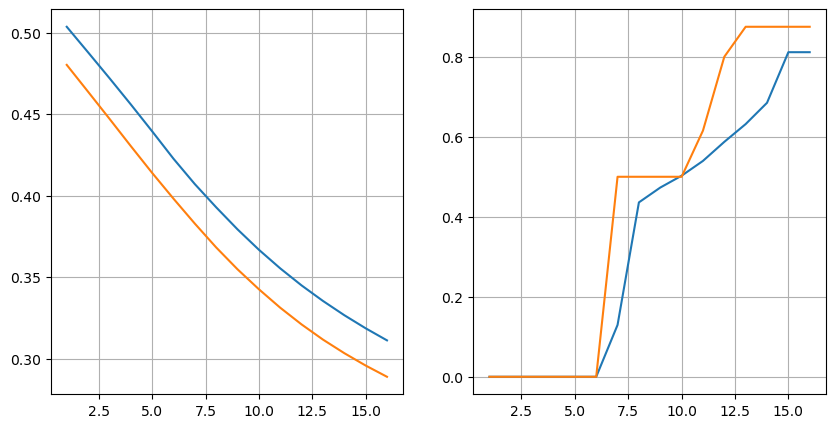

In [128]:
#학습 결과 확인(학습과 검증의 Loss, 성능지표 변화 확인) w. 시각화
import matplotlib.pyplot as plt

th=len(score_history[1])
fg,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1,th+1),loss_history[0][:th],label='Train')
axes[0].plot(range(1,th+1),loss_history[1][:th],label='Val')
axes[0].grid()
axes[0].legend

axes[1].plot(range(1,th+1),score_history[0][:th],label='Train')
axes[1].plot(range(1,th+1),score_history[1][:th],label='Val')
axes[1].grid()
axes[1].legend

plt.show()